In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import pytesseract
import keras_ocr
import os

from pytesseract import Output
from PIL import Image
from glob import glob

In [56]:
fold_path = os.getenv('HOME')+'/aiffel/ocr_python/'
images_path = glob(fold_path+'*.jpeg')
images_path

['/home/aiffel0042/aiffel/ocr_python/16.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/14.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/05.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/06.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/03.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/02..jpeg',
 '/home/aiffel0042/aiffel/ocr_python/12.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/20.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/13.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/15.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/11.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/01.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/18.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/10.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/17.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/04.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/08.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/07.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/09.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/19.jpeg']

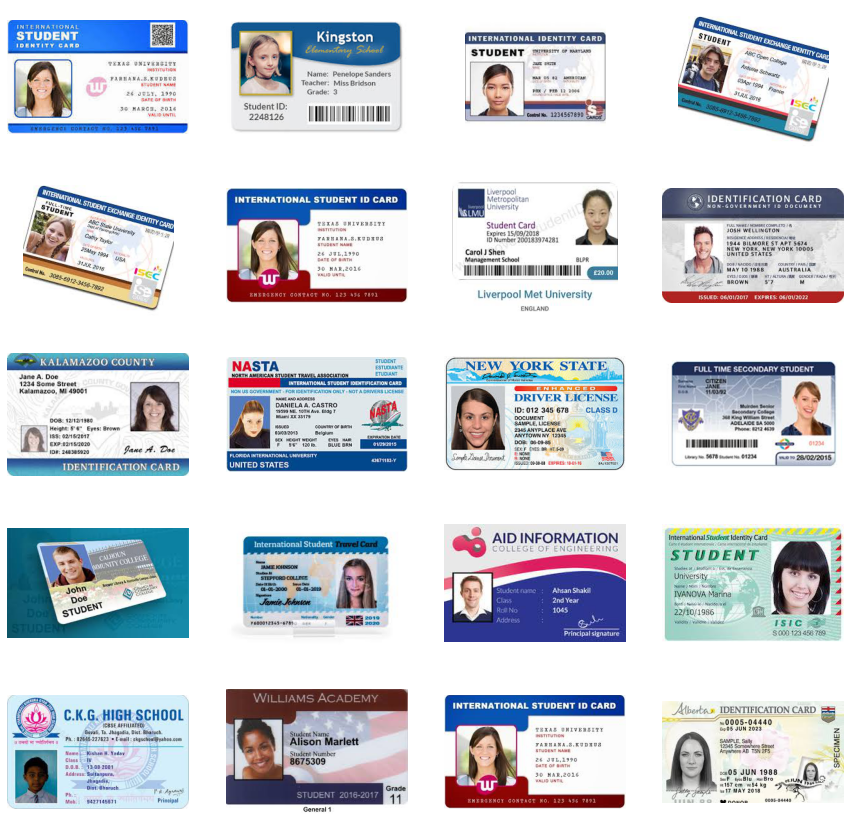

In [16]:
plt.figure(figsize=(15, 15))

for idx, im in enumerate(images):
    plt.subplot(5, 4, idx+1)
    im=img.imread(im)
    plt.imshow(im)
    plt.axis('off')

## OCR API

In [32]:
def detect_text(path):
    test = []
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()
    im=img.imread(path)
    plt.imshow(im)
    plt.axis('off')
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       #print('\n"{}"'.format(text.description))
        test.append(text.description)
    
    print(test)
    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

-rw-r--r-- 1 aiffel0042 aiffel0042 2346 10월  7 10:41 /home/aiffel0042/aiffel/ocr_python/my_google_api_key.json
Texts:
['INTERNATIONAL\nSTUDENT\nIDENTITY CARD\nTEXAS UNIVKRGITY\nINSTITUTION\nFARHANA.S.KUDEUS\nSTUDENT NAME\n26 JULY, 1990\nSATE OF SIRTH\n30 MARCB, 2016\nVALID UNTIL\nENRRGENGI CORTAGE KO, 123ATE 91\n', 'INTERNATIONAL', 'STUDENT', 'IDENTITY', 'CARD', 'TEXAS', 'UNIVKRGITY', 'INSTITUTION', 'FARHANA.S.KUDEUS', 'STUDENT', 'NAME', '26', 'JULY,', '1990', 'SATE', 'OF', 'SIRTH', '30', 'MARCB,', '2016', 'VALID', 'UNTIL', 'ENRRGENGI', 'CORTAGE', 'KO,', '123ATE', '91']
bounds: (190,144),(208,144),(208,155),(190,155)
Texts:
['Kingston\nElementary School\nName: Penelope Sanders\nTeacher: Miss Bridson\nGrade: 3\nStudent ID:\n2248126\n', 'Kingston', 'Elementary', 'School', 'Name:', 'Penelope', 'Sanders', 'Teacher:', 'Miss', 'Bridson', 'Grade:', '3', 'Student', 'ID:', '2248126']
bounds: (35,146),(86,147),(86,156),(35,155)
Texts:
['INTERNATIONAL IDENTITY CARD\nSTUDENT IVERSITY OP MARYLASD\n

Texts:
['C.K.G. HIGH SCHOOL\n(CBSE AFFILIATED)\nGavali, Ta. Jhagadia, Dist. Bharuch.\nPh. : 02645-227623 Email : ekgschool@yahoo.com\nName Kishan H. Yadav\nClassIV\nD.0.B.: 13.08 2001\nAddress: Sultanpura,\nJhagadis\nDist. Bharuch\nPh.:\nMob.\n9427145671\nPrincipal\nSCHOOL\n', 'C.K.G.', 'HIGH', 'SCHOOL', '(CBSE', 'AFFILIATED)', 'Gavali,', 'Ta.', 'Jhagadia,', 'Dist.', 'Bharuch.', 'Ph.', ':', '02645-227623', 'Email', ':', 'ekgschool@yahoo.com', 'Name', 'Kishan', 'H.', 'Yadav', 'ClassIV', 'D.0.B.:', '13.08', '2001', 'Address:', 'Sultanpura,', 'Jhagadis', 'Dist.', 'Bharuch', 'Ph.:', 'Mob.', '9427145671', 'Principal', 'SCHOOL']
bounds: (240,93),(217,135),(200,126),(223,84)
Texts:
['WILLIAMS ACADEMY\nStudent Name\nAlison Marlett\nStudent Number\n8675309\nGrade\nSTUDENT 2016-2017\n11\nGeneral 1\n', 'WILLIAMS', 'ACADEMY', 'Student', 'Name', 'Alison', 'Marlett', 'Student', 'Number', '8675309', 'Grade', 'STUDENT', '2016-2017', '11', 'General', '1']
bounds: (152,175),(154,175),(154,181),(152,181)

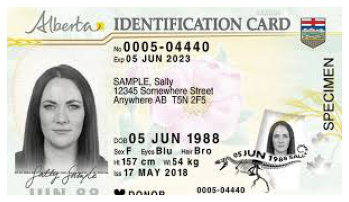

In [37]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

# 입력 이미지 경로를 지정해 주세요.
path = os.getenv('HOME')+'/aiffel/ocr_python/01.jpeg'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for path in images:
    detect_text(path)

## keras-ocr

In [ ]:
# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

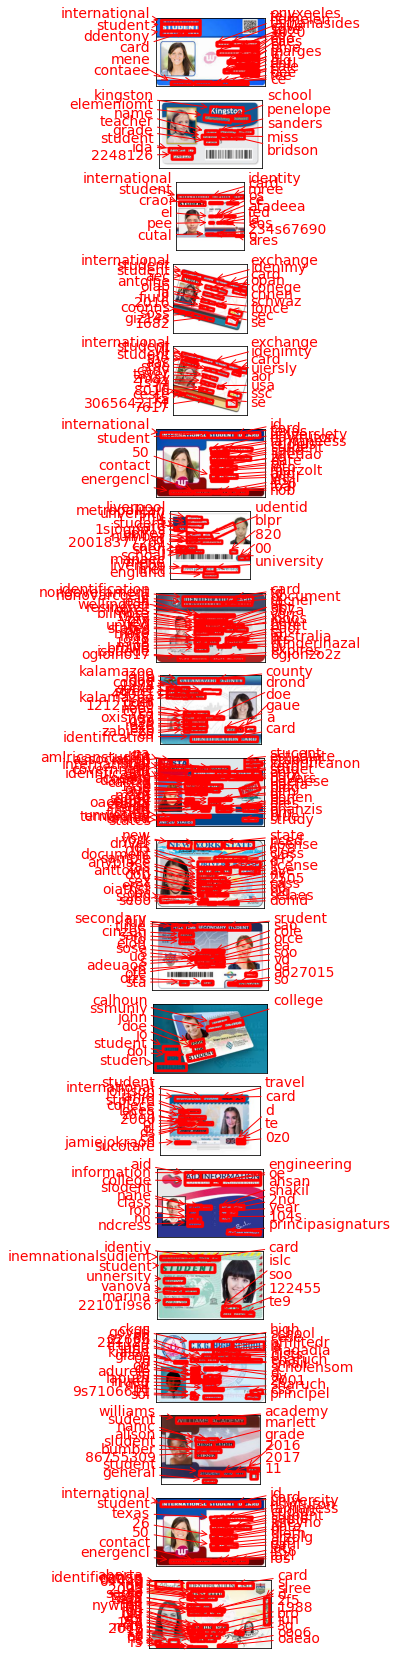

In [58]:
images = [ keras_ocr.tools.read(im) for im in images_path]
predictions = [pipeline.recognize([im]) for im in images_path]

# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(30, 30))

for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=predictions[idx][0], ax=ax)

## Tesseract

In [61]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
output_path = work_dir + '/output'
img_file_path = work_dir + '/01.jpeg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, output_path)

/home/aiffel0042/aiffel/ocr_python/output/0000.png
/home/aiffel0042/aiffel/ocr_python/output/0001.png
/home/aiffel0042/aiffel/ocr_python/output/0002.png
/home/aiffel0042/aiffel/ocr_python/output/0003.png
/home/aiffel0042/aiffel/ocr_python/output/0004.png
/home/aiffel0042/aiffel/ocr_python/output/0005.png
/home/aiffel0042/aiffel/ocr_python/output/0006.png
/home/aiffel0042/aiffel/ocr_python/output/0007.png
/home/aiffel0042/aiffel/ocr_python/output/0008.png
/home/aiffel0042/aiffel/ocr_python/output/0009.png
/home/aiffel0042/aiffel/ocr_python/output/0010.png
/home/aiffel0042/aiffel/ocr_python/output/0011.png
/home/aiffel0042/aiffel/ocr_python/output/0012.png
/home/aiffel0042/aiffel/ocr_python/output/0013.png
/home/aiffel0042/aiffel/ocr_python/output/0014.png
/home/aiffel0042/aiffel/ocr_python/output/0015.png
/home/aiffel0042/aiffel/ocr_python/output/0016.png


In [10]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)



느

1

시

조속

그

< ㅣ

( _』.2


구태

도우 )

를

-, 0

| 단일

.

14 7/니 /디1 | 년

1

응궁


이

(20294

“

오

0


수

대


이



^


9

:

서둘

간남 구

0

고!


1

고

12,

1

충

(논현동)

해

개

「

주


00

37-00183

난

원


(02-51 |-3235

단말기


여

~ 노11 44. |

0   르기 에


ㅣ

|


|

트여 아이 00000 2

* 감사합



~

아보 오0

|

{

|

|

| 652눅


|

|

아시고 저서

> &*1 전]

~

561

오즈

_

~

| _

| 2 [

가 ㄷ


버나

7

~

1 여

:

6250-03*^^-****-4903((:)

일시불

거

기

임ㅅ

|

애

2018) 01) 30

172 165 . 274

~

12 |

난 호

;

^

1] 11067

배월

'

0|

씨|

카느사

가맹


/4(1)()1(650 /

암럼

『

[[)

[내


나

2 2]


161 )1544-4700

가

사

합니다


16, /021027/)2 057/)201702157)0510

-거


0 겨

~

.

Done
